# CrowdTruth vs. MACE vs. Majority Vote for Recognizing Textual Entailment Annotation

This notebook contains a comparative analysis on the task of recognizing textual entailment between three approaches:

*   CrowdTruth
*   MACE (a probabilistic model that computes competence estimates of the individual annotators and the most likely answer to each item [1]) 
*   Majority Vote (the most common crowd annotation aggregation method). 

[1] Dirk Hovy, Taylor Berg-Kirkpatrick, Ashish Vaswani, and Eduard Hovy (2013): Learning Whom to Trust with MACE. In: Proceedings of NAACL-HLT 2013.

First we describe the task. Then, we apply the CrowdTruth metrics and identify clear and unclear example sentence. We then apply MACE. In the final part we perform two comparisons:

* CrowdTruth vs. MACE: workers' quality 
* CrowdTruth vs. MACE vs. Majority Vote: metrics performance in terms of F1-score (compared to expert, ground truth annotations)

**Data** This noteboook uses the data gathered in the "Recognizing Textual Entailment" crowdsourcing experiment published in *Rion Snow, Brendan O’Connor, Dan Jurafsky, and Andrew Y. Ng: Cheap and fast—but is it good? Evaluating non-expert annotations for natural language tasks. EMNLP 2008, pages 254–263*.

**Task Description**: Given *two sentences*, the crowd has to choose whether the second *hypothesis* sentence can be inferred from the first *sentence* (binary choice, true/false). Following, we provide an example from the aforementioned publication:

**Text**: “Crude Oil Prices Slump”

**Hypothesis**: “Oil prices drop”

A screenshot of the task as it appeared to workers can be seen at the following [repository](http://ai.stanford.edu/ ̃rion/annotations/).

The dataset for this task was downloaded from the following [repository](http://ai.stanford.edu/ ̃rion/annotations/), which contains the raw output from the crowd on AMT. Currently, you can find the processed input file in the folder named `data`. Besides the raw crowd annotations, the processed file also contains the text and the hypothesis that needs to be tested with the given text, which were given as input to the crowd.

In [1]:
#Read the input file into a pandas DataFrame

import pandas as pd

test_data = pd.read_csv("../data/rte.standardized.csv")
test_data.head()

,!amt_annotation_ids,!amt_worker_ids,orig_id,response,gold,start,end,hypothesis,task,text
0,1,A2K5ICP43ML4PW,25,0,0,Mon Mar 25 07:39:42 PDT 2019,Mon Mar 25 07:41:05 PDT 2019,Two films won six Oscars.,IR,"The film was the evening&apos;s big winner, ba..."
1,2,A15L6WGIK3VU7N,25,0,0,Mon Mar 25 07:39:42 PDT 2019,Mon Mar 25 07:41:05 PDT 2019,Two films won six Oscars.,IR,"The film was the evening&apos;s big winner, ba..."
2,3,AHPSMRLKAEJV,25,0,0,Mon Mar 25 07:39:42 PDT 2019,Mon Mar 25 07:41:05 PDT 2019,Two films won six Oscars.,IR,"The film was the evening&apos;s big winner, ba..."
3,4,A25QX7IUS1KI5E,25,0,0,Mon Mar 25 07:39:42 PDT 2019,Mon Mar 25 07:41:05 PDT 2019,Two films won six Oscars.,IR,"The film was the evening&apos;s big winner, ba..."
4,5,A2RV3FIO3IAZS,25,0,0,Mon Mar 25 07:39:42 PDT 2019,Mon Mar 25 07:41:05 PDT 2019,Two films won six Oscars.,IR,"The film was the evening&apos;s big winner, ba..."


## Declaring a pre-processing configuration

The pre-processing configuration defines how to interpret the raw crowdsourcing input. To do this, we need to define a configuration class. First, we import the default CrowdTruth configuration class:

In [2]:
import crowdtruth
from crowdtruth.configuration import DefaultConfig

Our test class inherits the default configuration `DefaultConfig`, while also declaring some additional attributes that are specific to the Recognizing Textual Entailment task:

* **`inputColumns`:** list of input columns from the .csv file with the input data
* **`outputColumns`:** list of output columns from the .csv file with the answers from the workers
* **`customPlatformColumns`:** a list of columns from the .csv file that defines a standard annotation tasks, in the following order - judgment id, unit id, worker id, started time, submitted time. This variable is used for input files that do not come from AMT or FigureEight (formarly known as CrowdFlower).
* **`annotation_separator`:** string that separates between the crowd annotations in `outputColumns`
* **`open_ended_task`:** boolean variable defining whether the task is open-ended (i.e. the possible crowd annotations are not known beforehand, like in the case of free text input); in the task that we are processing, workers pick the answers from a pre-defined list, therefore the task is not open ended, and this variable is set to `False`
* **`annotation_vector`:** list of possible crowd answers, mandatory to declare when `open_ended_task` is `False`; for our task, this is the list of relations
* **`processJudgments`:** method that defines processing of the raw crowd data; for this task, we process the crowd answers to correspond to the values in `annotation_vector`

The complete configuration class is declared below:

In [3]:
class TestConfig(DefaultConfig):
    inputColumns = ["gold", "task", "text", "hypothesis"]
    outputColumns = ["response"]
    customPlatformColumns = ["!amt_annotation_ids", "orig_id", "!amt_worker_ids", "start", "end"]
    
    # processing of a closed task
    open_ended_task = False
    annotation_vector = ["0", "1"]
    
    def processJudgments(self, judgments):
        # pre-process output to match the values in annotation_vector
        for col in self.outputColumns:
            # transform to lowercase
            judgments[col] = judgments[col].apply(lambda x: str(x).lower())
        return judgments

## Pre-processing the input data

After declaring the configuration of our input file, we are ready to pre-process the crowd data:

In [4]:
data, config = crowdtruth.load(
    file = "../data/rte.standardized.csv",
    config = TestConfig()
)

data['judgments'].head()

,output.response,output.response.count,output.response.unique,started,unit,submitted,worker,duration,job
judgment,,,,,,,,,
1,"{u'0': 1, u'1': 0}",1,2,2019-03-25 07:39:42-07:00,25,2019-03-25 07:41:05-07:00,A2K5ICP43ML4PW,83,../data/rte.standardized
2,"{u'0': 1, u'1': 0}",1,2,2019-03-25 07:39:42-07:00,25,2019-03-25 07:41:05-07:00,A15L6WGIK3VU7N,83,../data/rte.standardized
3,"{u'0': 1, u'1': 0}",1,2,2019-03-25 07:39:42-07:00,25,2019-03-25 07:41:05-07:00,AHPSMRLKAEJV,83,../data/rte.standardized
4,"{u'0': 1, u'1': 0}",1,2,2019-03-25 07:39:42-07:00,25,2019-03-25 07:41:05-07:00,A25QX7IUS1KI5E,83,../data/rte.standardized
5,"{u'0': 1, u'1': 0}",1,2,2019-03-25 07:39:42-07:00,25,2019-03-25 07:41:05-07:00,A2RV3FIO3IAZS,83,../data/rte.standardized


## Computing the CrowdTruth metrics

The pre-processed data can then be used to calculate the CrowdTruth metrics. `results` is a dict object that contains the quality metrics for the sentences, annotations and crowd workers.

In [5]:
results = crowdtruth.run(data, config)

# CrowdTruth Sentence Quality Score

The **sentence metrics** are stored in `results["units"]`. The `uqs` column in `results["units"]` contains the **sentence quality scores**, capturing the overall workers agreement over each sentences. The `uqs_initial` column in `results["units"]` contains the **initial sentence quality scores**, before appling the CrowdTruth metrics.

In [6]:
results["units"].head()

,duration,input.gold,input.hypothesis,input.task,input.text,job,output.response,output.response.annotations,output.response.unique_annotations,worker,uqs,unit_annotation_score,uqs_initial,unit_annotation_score_initial
unit,,,,,,,,,,,,,,
25,83,0,Two films won six Oscars.,IR,"The film was the evening&apos;s big winner, ba...",../data/rte.standardized,"{u'1': 2, u'0': 8}",10,2,10,0.754990,"{u'1': 0.125120938705, u'0': 0.874879061295}",0.644444,"{u'1': 0.2, u'0': 0.8}"
35,83,1,Saudi Arabia is the world&apos;s biggest oil e...,PP,"Saudi Arabia, the biggest oil producer in the ...",../data/rte.standardized,"{u'1': 4, u'0': 6}",10,2,10,0.529058,"{u'1': 0.299717609209, u'0': 0.700282390791}",0.466667,"{u'1': 0.4, u'0': 0.6}"
39,83,1,Bill Clinton received a reported $10 million a...,PP,Mr. Clinton received a hefty advance for the b...,../data/rte.standardized,"{u'1': 9, u'0': 1}",10,2,10,0.877036,"{u'1': 0.941931841284, u'0': 0.0580681587159}",0.800000,"{u'1': 0.9, u'0': 0.1}"
48,83,1,Clinton is articulate.,PP,Clinton is a very charismatic person.,../data/rte.standardized,"{u'1': 4, u'0': 6}",10,2,10,0.526438,"{u'1': 0.302639972687, u'0': 0.697360027313}",0.466667,"{u'1': 0.4, u'0': 0.6}"
49,83,1,Argentina sees upsurge in kidnappings.,IR,Kidnappings in Argentina have increased more t...,../data/rte.standardized,"{u'1': 10, u'0': 0}",10,1,10,1.000000,"{u'1': 1.0, u'0': 0.0}",1.000000,"{u'1': 1.0, u'0': 0.0}"


Text(0,0.5,'# Units')

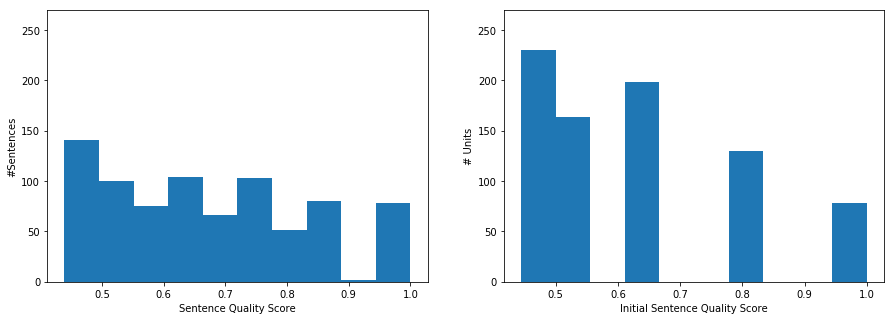

In [7]:
# Distribution of the sentence quality scores and the initial sentence quality scores

import matplotlib.pyplot as plt
%matplotlib inline

plt.rcParams['figure.figsize'] = 15, 5

plt.subplot(1, 2, 1)
plt.hist(results["units"]["uqs"])
plt.ylim(0,270)
plt.xlabel("Sentence Quality Score")
plt.ylabel("#Sentences")

plt.subplot(1, 2, 2)
plt.hist(results["units"]["uqs_initial"])
plt.ylim(0,270)
plt.xlabel("Initial Sentence Quality Score")
plt.ylabel("# Units")


The histograms above show that the final **sentence quality scores** are nicely distributed, with both lower and high quality sentences. We also observe that, overall, the **sentence quality score** increased after applying the CrowdTruth metrics, compared to the **initial sentence quality scores**. 

The **sentence quality score** is a powerful measure to understand how clear the sentence is and the suitability of the sentence to be used as training data for various machine learning models.

The `unit_annotation_score` column in `results["units"]` contains the **sentence-annotation scores**, capturing the likelihood that an annotation is expressed in a sentence. For each sentence, we store a dictionary mapping each annotation to its sentence-annotation score.

In [8]:
results["units"]["unit_annotation_score"].head()

unit
25     {u'1': 0.125120938705, u'0': 0.874879061295}
35     {u'1': 0.299717609209, u'0': 0.700282390791}
39    {u'1': 0.941931841284, u'0': 0.0580681587159}
48     {u'1': 0.302639972687, u'0': 0.697360027313}
49                           {u'1': 1.0, u'0': 0.0}
Name: unit_annotation_score, dtype: object

## Example of a clear unit based on the CrowdTruth metrics

First, we sort the **sentence metrics** stored in *results["units"]* based on the **sentence quality score (uqs)**, in ascending order. Thus, the most clear sentences are found at the tail of the new structure:

In [9]:
sortedUQS = results["units"].sort_values(["uqs"])
sortedUQS = sortedUQS.reset_index()

We print the most clear unit, which is the last unit in sortedUQS:

In [10]:
sortedUQS.tail(1)

,unit,duration,input.gold,input.hypothesis,input.task,input.text,job,output.response,output.response.annotations,output.response.unique_annotations,worker,uqs,unit_annotation_score,uqs_initial,unit_annotation_score_initial
799,1017,83,1,The Pamplona fiesta has been celebrated for ce...,RC,The centuries-old Pamplona fiesta in honor of ...,../data/rte.standardized,"{u'1': 10, u'0': 0}",10,1,10,1.0,"{u'1': 1.0, u'0': 0.0}",1.0,"{u'1': 1.0, u'0': 0.0}"


The unit below is very clear because the text contains high overlap with the hypothesis. The relevance can be observed in the following parts of the hypothesis and of the text: *"Pamplona fiesta has been celebrated for centuries"* and *"The centuries-old Pamplona fiesta"*.

In [11]:
print("Hypothesis: %s" % sortedUQS["input.hypothesis"].iloc[len(sortedUQS.index)-1])
print("Text: %s" % sortedUQS["input.text"].iloc[len(sortedUQS.index)-1])
print("Expert Answer: %s" % sortedUQS["input.gold"].iloc[len(sortedUQS.index)-1])
print("Crowd Answer with CrowdTruth: %s" % sortedUQS["unit_annotation_score"].iloc[len(sortedUQS.index)-1])
print("Crowd Answer without CrowdTruth: %s" % sortedUQS["unit_annotation_score_initial"].iloc[len(sortedUQS.index)-1])

Hypothesis: The Pamplona fiesta has been celebrated for centuries.
Text: The centuries-old Pamplona fiesta in honor of St. Fermin draws thousands of fans from around the world for a week of frenzied late night drinking and early morning running with the bulls.
Expert Answer: 1
Crowd Answer with CrowdTruth: Counter({'1': 1.0, '0': 0.0})
Crowd Answer without CrowdTruth: Counter({'1': 1.0, '0': 0.0})


## Example of an unclear unit based on the CrowdTruth metrics

We use the same structure as above and we print the most unclear unit, which is the first unit in sortedUQS:

In [12]:
sortedUQS.head(1)

,unit,duration,input.gold,input.hypothesis,input.task,input.text,job,output.response,output.response.annotations,output.response.unique_annotations,worker,uqs,unit_annotation_score,uqs_initial,unit_annotation_score_initial
0,1521,83,1,Apartheid in South Africa was abolished in 1990.,QA,"On 2 February 1990, at the opening of Parliame...",../data/rte.standardized,"{u'1': 5, u'0': 5}",10,2,10,0.439065,"{u'1': 0.507491408227, u'0': 0.492508591773}",0.444444,"{u'1': 0.5, u'0': 0.5}"


The unit below is very unclear because the text and the hypothesis contain overlapping words such as *"1990"* and *"apartheid"* and phrases that could be related, such as *"South Africa" - "ANC"* or *"abolished" - "were to be lifted"*, but a clear relevance between the two can not be shown.

In [13]:
print("Hypothesis: %s" % sortedUQS["input.hypothesis"].iloc[0])
print("Text: %s" % sortedUQS["input.text"].iloc[0])
print("Expert Answer: %s" % sortedUQS["input.gold"].iloc[0])
print("Crowd Answer with CrowdTruth: %s" % sortedUQS["unit_annotation_score"].iloc[0])
print("Crowd Answer without CrowdTruth: %s" % sortedUQS["unit_annotation_score_initial"].iloc[0])

Hypothesis: Apartheid in South Africa was abolished in 1990.
Text: On 2 February 1990, at the opening of Parliament, he declared that apartheid had failed and that the bans on political parties, including the ANC, were to be lifted.
Expert Answer: 1
Crowd Answer with CrowdTruth: Counter({'1': 0.5074914082267219, '0': 0.4925085917732781})
Crowd Answer without CrowdTruth: Counter({'1': 0.5, '0': 0.5})


# CrowdTruth Worker Quality Scores

The **worker metrics** are stored in `results["workers"]`. The `wqs` columns in `results["workers"]` contains the **worker quality scores**, capturing the overall agreement between one worker and all the other workers.  The `wqs_initial` column in `results["workers"]` contains the **initial worker quality scores**, before appling the CrowdTruth metrics. 

In [14]:
results["workers"].head()

,duration,job,judgment,unit,wqs,wwa,wsa,wqs_initial,wwa_initial,wsa_initial
worker,,,,,,,,,,
A11GX90QFWDLMM,83,1,760,760,0.342472,0.544462,0.629009,0.334467,0.525292,0.636726
A14JQX7IFAICP0,83,1,180,180,0.414908,0.595823,0.696362,0.379697,0.555556,0.683455
A14Q86RX5HGCN,83,1,20,20,0.821105,0.852668,0.962983,0.733456,0.788889,0.929733
A14WWG6NKBDWGP,83,1,20,20,0.678581,0.754595,0.899265,0.571740,0.677778,0.843551
A151VN1BOY29J1,83,1,40,40,0.690083,0.780349,0.884326,0.582732,0.697222,0.835791


Text(0,0.5,'#Workers')

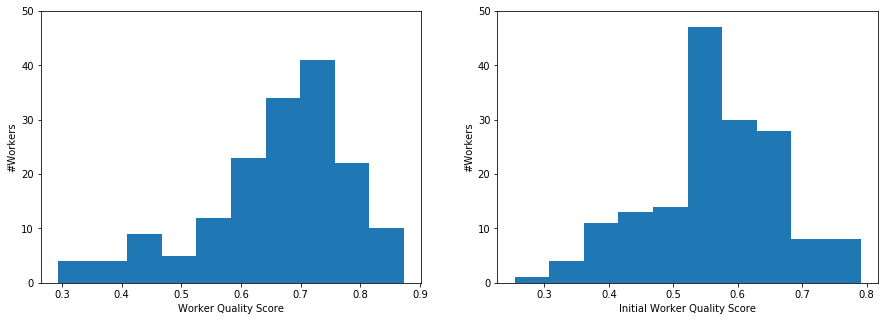

In [15]:
# Distribution of the worker quality scores and the initial worker quality scores

plt.rcParams['figure.figsize'] = 15, 5

plt.subplot(1, 2, 1)
plt.hist(results["workers"]["wqs"])
plt.ylim(0,50)
plt.xlabel("Worker Quality Score")
plt.ylabel("#Workers")

plt.subplot(1, 2, 2)
plt.hist(results["workers"]["wqs_initial"])
plt.ylim(0,50)
plt.xlabel("Initial Worker Quality Score")
plt.ylabel("#Workers")



The histograms above shows the **worker quality scores** and the **initial worker quality scores**. We observe that the worker quality scores are distributed across a wide spectrum, from low to high quality workers. Furthermore, the **worker quality scores** seem to have a more normal distribution after computing the CrowdTruth iterations, compared to the **initial worker quality scores**.

Low worker quality scores can be used to identify **spam workers**, or workers that have misunderstood the annotation task. Similarly, high worker quality scores can be used to identify **well performing workers**.

# CrowdTruth Annotation Quality Score

The **annotation metrics** are stored in `results["annotations"]`. The `aqs` column contains the **annotation quality scores**, capturing the overall worker agreement over one annotation.

In [16]:
results["annotations"]

,output.response,aqs,aqs_initial
0,8000,0.706485,0.616694
1,8000,0.793250,0.715569


In the dataframe above we observe that after iteratively computing the **sentence quality scores** and the **worker quality scores** the overall agreement on the annotations increased. This can be seen when comparing the **annotation quality scores** with the **initial annotation quality scores**.

# MACE for Recognizing Textual Entailment Annotation

We first pre-processed the crowd results to create compatible files for running the MACE tool.
Each row in a csv file should point to a unit in the dataset and each column in the csv file should point to a worker. The content of the csv file captures the worker answer for that particular unit (or remains empty if the worker did not annotate that unit).

The following implementation of **MACE** has been used in these experiments: https://github.com/dirkhovy/MACE.

In [17]:
# MACE input file sample
import numpy as np

mace_test_data = pd.read_csv("../data/mace_rte.standardized.csv", header=None)
mace_test_data = test_data.replace(np.nan, '', regex=True)
mace_test_data.head()

,!amt_annotation_ids,!amt_worker_ids,orig_id,response,gold,start,end,hypothesis,task,text
0,1,A2K5ICP43ML4PW,25,0,0,Mon Mar 25 07:39:42 PDT 2019,Mon Mar 25 07:41:05 PDT 2019,Two films won six Oscars.,IR,"The film was the evening&apos;s big winner, ba..."
1,2,A15L6WGIK3VU7N,25,0,0,Mon Mar 25 07:39:42 PDT 2019,Mon Mar 25 07:41:05 PDT 2019,Two films won six Oscars.,IR,"The film was the evening&apos;s big winner, ba..."
2,3,AHPSMRLKAEJV,25,0,0,Mon Mar 25 07:39:42 PDT 2019,Mon Mar 25 07:41:05 PDT 2019,Two films won six Oscars.,IR,"The film was the evening&apos;s big winner, ba..."
3,4,A25QX7IUS1KI5E,25,0,0,Mon Mar 25 07:39:42 PDT 2019,Mon Mar 25 07:41:05 PDT 2019,Two films won six Oscars.,IR,"The film was the evening&apos;s big winner, ba..."
4,5,A2RV3FIO3IAZS,25,0,0,Mon Mar 25 07:39:42 PDT 2019,Mon Mar 25 07:41:05 PDT 2019,Two films won six Oscars.,IR,"The film was the evening&apos;s big winner, ba..."


For each sentence and each annotation, MACE computes  the **sentence annotation probability score**, which shows the probability of each annotation to be expressed in the sentence. **MACE sentence annotation probability score** is similar to the **CrowdTruth sentence-annotation score**.

In [18]:
# MACE sentence annotation probability scores:

import pandas as pd

mace_data = pd.read_csv("../data/results/mace_units_rte.csv")
mace_data.head()

,unit,true,false,gold
0,25,9.263818e-06,9.999907e-01,0
1,35,1.353801e-06,9.999986e-01,1
2,39,1.000000e+00,1.057981e-08,1
3,48,5.895417e-07,9.999994e-01,1
4,49,9.999986e-01,1.420726e-06,1


For each worker in the annotators set we have **MACE worker competence score**, which is similar to the **CrowdTruth worker quality score**.

In [19]:
# MACE worker competence scores
mace_workers = pd.read_csv("../data/results/mace_workers_rte.csv")
mace_workers.head()

,worker,competence
0,A2K5ICP43ML4PW,0.804252
1,A15L6WGIK3VU7N,0.855198
2,AHPSMRLKAEJV,0.690429
3,A25QX7IUS1KI5E,0.473449
4,A2RV3FIO3IAZS,0.348140


# CrowdTruth vs. MACE on Worker Quality

We read the worker quality scores as returned by CrowdTruth and MACE and merge the two dataframes:

In [20]:
mace_workers = pd.read_csv("../data/results/mace_workers_rte.csv")
crowdtruth_workers = pd.read_csv("../data/results/crowdtruth_workers_rte.csv")

workers_scores = pd.merge(mace_workers, crowdtruth_workers, on='worker')
workers_scores = workers_scores.sort_values(["wqs"])
workers_scores.head()

,worker,competence,duration,job,judgment,unit,wqs,wwa,wsa,wqs_initial,wwa_initial,wsa_initial
142,ADX3CN405XAMF,0.137945,83,1,20,20,0.293809,0.497769,0.590251,0.253719,0.450000,0.563820
9,A11GX90QFWDLMM,0.013396,83,1,760,760,0.342472,0.544462,0.629009,0.334467,0.525292,0.636726
146,A1ZIUN0W12X1SP,0.173226,83,1,20,20,0.348353,0.537367,0.648259,0.334848,0.511111,0.655136
12,A1Q4VUJBMY78YR,0.004383,83,1,540,540,0.351446,0.548064,0.641250,0.344728,0.529630,0.650885
6,A18941IO2ZZWW6,0.007900,83,1,800,800,0.355375,0.555106,0.640193,0.345802,0.535139,0.646192


Plot the quality scores of the workers as computed by both CrowdTruth and MACE:

Text(0,0.5,'CrowdTruth')

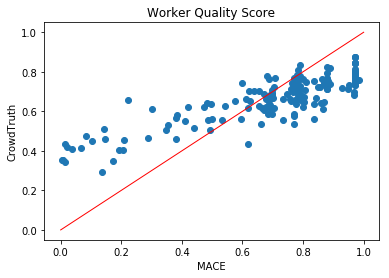

In [21]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt

plt.scatter(
    workers_scores["competence"],
    workers_scores["wqs"],
)
plt.plot([0, 1], [0, 1], 'red', linewidth=1)
plt.title("Worker Quality Score")
plt.xlabel("MACE")
plt.ylabel("CrowdTruth")

In the plot above we observe that **MACE** favours extreme values, which means that the identified low quality workers will have very low scores, e.g., below 0.2 and the best workers will have quality scores of 1.0, or very close to 1.0. On the other side, **CrowdTruth** has a smaller interval of values, starting from around 0.25 to 0.9.

Following, we compute the correlation between the two values using Spearman correlation and Kendall's tau correlation, to see whether the two values are correlated. More exactly, we want to see whether, overall, both metrics identify as low quality or high quality similar workers, or they are really divergent in their outcome.

In [22]:
from scipy.stats import spearmanr
x = workers_scores["wqs"]

x_corr = workers_scores["competence"]
corr, p_value = spearmanr(x, x_corr)
print ("correlation: ", corr)
print ("p-value: ", p_value)

('correlation: ', 0.7915227849515961)
('p-value: ', 1.783362816046852e-36)


Spearman correlation shows shows a strong to very strong correlation between the two computed values, and the correlation is significant. This means that overall, even if the two metrics provide different values, they are indeed correlated and low quality workers receive low scores and high quality workers receive higher scores from both aggregation methods.

In [23]:
from scipy.stats import kendalltau
x1 = workers_scores["wqs"]
x2 = workers_scores["competence"]

tau, p_value = kendalltau(x1, x2)
print ("correlation: ", tau)
print ("p-value: ", p_value)

('correlation: ', 0.6097305457542687)
('p-value: ', 4.983047800836028e-31)


Even with Kendall's tau rank correlation, we observe a moderate to strong correlation between the two computed values, where the correlation is significant.

Further, we compute the difference of the two quality scores and we check one worker for which the difference is very high.

In [24]:
workers_scores["diff"] = workers_scores["wqs"] - workers_scores["competence"]
workers_scores = workers_scores.sort_values(["diff"])
workers_scores.tail(5)

,worker,competence,duration,job,judgment,unit,wqs,wwa,wsa,wqs_initial,wwa_initial,wsa_initial,diff
150,A3N3ESBU769SMG,0.036518,83,1,20,20,0.409560,0.591506,0.692402,0.387835,0.561111,0.691191,0.373042
130,A1SM3O307GMDK8,0.082561,83,1,40,40,0.476500,0.650799,0.732178,0.441613,0.613889,0.719370,0.393940
139,A2CET0W1FJGMV,0.020458,83,1,20,20,0.420838,0.584645,0.719817,0.427066,0.577778,0.739152,0.400380
135,A2QPX2MS844TYJ,0.013133,83,1,20,20,0.434001,0.578678,0.749987,0.410131,0.561111,0.730927,0.420868
131,AZKV0OXDZVDYR,0.221891,83,1,20,20,0.655702,0.739255,0.886977,0.589379,0.688889,0.855550,0.433811


We take for example the worker with the id "**A2QPX2MS844TYJ**" and check the overall disagreement among the workers on the units annotated by them. **MACE** rated the worker with a **quality score of 0.01** while **CrowdTruth** rated the worker with a **quality score of 0.43**

What we observe in the dataframe below, where we show the units annotated by the worker  "**A2QPX2MS844TYJ**", is that the worker "**A2QPX2MS844TYJ**" annotated, in general, **units with high disagreement**, i.e., which are not very clear. While **MACE** marked the worker as low quality because it seems that they **always picked the same answer**, **CrowdTruth also considered the difficulty of the units**, and thus, giving it a higher weight. 

In [25]:
# Sample of sentences annotated by worker A2QPX2MS844TYJ

units = list(test_data[test_data["!amt_worker_ids"] == "A2QPX2MS844TYJ"]["orig_id"])
units_df = sortedUQS[sortedUQS["unit"].isin(units)]
units_df = units_df.sort_values(["uqs_initial"])
units_df

,unit,duration,input.gold,input.hypothesis,input.task,input.text,job,output.response,output.response.annotations,output.response.unique_annotations,worker,uqs,unit_annotation_score,uqs_initial,unit_annotation_score_initial
20,2093,83,0,Said to Wednesday the astronomers.,MT,Astronomers said on Wednesday.,../data/rte.standardized,"{u'1': 5, u'0': 5}",10,2,10,0.442144,"{u'1': 0.504695253954, u'0': 0.495304746046}",0.444444,"{u'1': 0.5, u'0': 0.5}"
36,1236,83,0,The Queen of Jordan will be released from Roch...,MT,The hospital where the Jordanian monarch is be...,../data/rte.standardized,"{u'1': 5, u'0': 5}",10,2,10,0.445643,"{u'1': 0.45992700804, u'0': 0.54007299196}",0.444444,"{u'1': 0.5, u'0': 0.5}"
39,1290,83,1,"Describing the scene, Dalako Salwati (19) said...",MT,Other witnesses confirmed that rescue workers ...,../data/rte.standardized,"{u'1': 5, u'0': 5}",10,2,10,0.446027,"{u'1': 0.542039760004, u'0': 0.457960239996}",0.444444,"{u'1': 0.5, u'0': 0.5}"
40,1328,83,0,In spite of those disparities it is none preve...,MT,"Despite these differences, nothing prevents a ...",../data/rte.standardized,"{u'1': 5, u'0': 5}",10,2,10,0.446188,"{u'1': 0.456975089895, u'0': 0.543024910105}",0.444444,"{u'1': 0.5, u'0': 0.5}"
147,1337,83,0,"Was Aliyev declared victory, since yesterday T...",MT,"Aliyev had proclaimed his win yesterday, Tuesd...",../data/rte.standardized,"{u'1': 4, u'0': 6}",10,2,10,0.499543,"{u'1': 0.339334600383, u'0': 0.660665399617}",0.466667,"{u'1': 0.4, u'0': 0.6}"
135,1322,83,0,Cohen supports force in making Iraq disarm.,MT,A diplomatic source reported that countries of...,../data/rte.standardized,"{u'1': 4, u'0': 6}",10,2,10,0.489734,"{u'1': 0.353751991509, u'0': 0.646248008491}",0.466667,"{u'1': 0.4, u'0': 0.6}"
119,1356,83,0,An official source announced of South Africa N...,MT,"The President of South Africa, Nelson Mandela,...",../data/rte.standardized,"{u'1': 6, u'0': 4}",10,2,10,0.482546,"{u'1': 0.634595271346, u'0': 0.365404728654}",0.466667,"{u'1': 0.6, u'0': 0.4}"
139,1275,83,1,The fire happened in the early hours of Friday...,MT,"The spokesman for the rescue authorities, Lina...",../data/rte.standardized,"{u'1': 6, u'0': 4}",10,2,10,0.491707,"{u'1': 0.649113573261, u'0': 0.350886426739}",0.466667,"{u'1': 0.6, u'0': 0.4}"
72,1318,83,0,The Asian economic crash affected the Euro.,MT,"The chief of the European Central Bank, Vim Du...",../data/rte.standardized,"{u'1': 6, u'0': 4}",10,2,10,0.460261,"{u'1': 0.59013738007, u'0': 0.40986261993}",0.466667,"{u'1': 0.6, u'0': 0.4}"
46,1282,83,0,"Nick Zuniga, an economist in &quot;Kerry Group...",MT,"Nick Parsons, an economic expert at &quot;Pari...",../data/rte.standardized,"{u'1': 6, u'0': 4}",10,2,10,0.448329,"{u'1': 0.552691963231, u'0': 0.447308036769}",0.466667,"{u'1': 0.6, u'0': 0.4}"


# CrowdTruth vs. MACE vs. Majority Vote on Annotation Performance

Next, we look into the **crowd performance in terms of F1-score** compared to expert annotations. We compare the crowd performance given the three aggregation methods: **CrowdTruth**, **MACE** and **Majority Vote**. We read the result files as given by MACE and CrowdTruth.

In [26]:
import pandas as pd 
import numpy as np

mace = pd.read_csv("../data/results/mace_units_rte.csv")
crowdtruth = pd.read_csv("../data/results/crowdtruth_units_rte.csv")

The following two functions compute the F1-score of the crowd compared to the expert annotations. The first function computes the F1-score at every sentence-annotation score threshold. The second function computes the F1-score for the majority vote approach, i.e., when at least half of the workers picked the answer.

In [27]:
def compute_F1_score(dataset, label, gold_column, gold_value):
    nyt_f1 = np.zeros(shape=(100, 2))
    for idx in xrange(0, 100):
        thresh = (idx + 1) / 100.0
        tp = 0
        fp = 0
        tn = 0
        fn = 0

        for gt_idx in range(0, len(dataset.index)):
            if dataset[label].iloc[gt_idx] >= thresh:
                if dataset[gold_column].iloc[gt_idx] == gold_value:
                    tp = tp + 1.0
                else:
                    fp = fp + 1.0
            else:
                if dataset[gold_column].iloc[gt_idx] == gold_value:
                    fn = fn + 1.0
                else:
                    tn = tn + 1.0


        nyt_f1[idx, 0] = thresh
    
        if tp != 0:
            nyt_f1[idx, 1] = 2.0 * tp / (2.0 * tp + fp + fn)
        else:
            nyt_f1[idx, 1] = 0
    return nyt_f1


def compute_majority_vote(dataset, label, gold_column, gold_value):
    tp = 0
    fp = 0
    tn = 0
    fn = 0
    
    for j in range(len(dataset.index)):
        if dataset[label].iloc[j] >= 0.5:
            if dataset[gold_column].iloc[j] == gold_value:
                tp = tp + 1.0
            else:
                fp = fp + 1.0
        else:
            if dataset[gold_column].iloc[j] == gold_value:
                fn = fn + 1.0
            else:
                tn = tn + 1.0
    return 2.0 * tp / (2.0 * tp + fp + fn)

F1-score for the annotation "1" or "true":

In [28]:
F1_crowdtruth = compute_F1_score(crowdtruth, "true", "gold", 1)
print("Best CrowdTruth F1 score for annotation 'true': ", F1_crowdtruth[F1_crowdtruth[:,1].argsort()][-1:])
F1_mace = compute_F1_score(mace, "true", "gold", 1)
print("Best MACE F1 score for annotation 'true': ", F1_mace[F1_mace[:,1].argsort()][-1:])
F1_majority_vote = compute_majority_vote(crowdtruth, 'true_initial', "gold", 1)
print("Majority Vote F1 score for annotation 'true': ", F1_majority_vote)

("Best CrowdTruth F1 score for annotation 'true': ", array([[0.52     , 0.9280397]]))
("Best MACE F1 score for annotation 'true': ", array([[0.11      , 0.93099122]]))
("Majority Vote F1 score for annotation 'true': ", 0.8853211009174312)


From the results above we observe that **MACE** and **CrowdTruth** perform very close to each other, and they both perform much better than **Majority Vote**. As we can observe in the overall **initial sentence quality score**, there are many unclear sentences in the dataset where half of the workers picked "true" as an answer and half as "false" (more than 220 examples out of 800). In this case, the **Majority Vote** approach is not desirable since picking the right answer might not be better than throwing a coin. However, approaches that account for unit difficulty and workers quality (such as **CrowdTruth** and **MACE**) are more suitable. 

To further explore the **CrowdTruth and MACE quality metrics**, download the aggregation results in .csv format for:

* [CrowdTruth units quality](https://github.com/CrowdTruth/CrowdTruth-core/blob/master/tutorial/data/results/crowdtruth_units_rte.csv)
* [CrowdTruth workers quality](https://github.com/CrowdTruth/CrowdTruth-core/blob/master/tutorial/data/results/crowdtruth_workers_rte.csv)
* [MACE units quality](https://github.com/CrowdTruth/CrowdTruth-core/blob/master/tutorial/data/results/mace_units_rte.csv)
* [MACE workers quality](https://github.com/CrowdTruth/CrowdTruth-core/blob/master/tutorial/data/results/mace_workers_rte.csv)